In [54]:
import matplotlib.pyplot as plt
import numpy as np
# import skimage as ski
import scipy
from PIL import Image

In [2]:
# Reusing Functions from Assignment 1
def withinClassVar(image, t):
    histo = Histogram(image)
    histo_norm = histo / np.sum(histo)
    w0 = np.sum(histo_norm[:t+1])
    w1 = 1 - w0
    
    #error control divide by 0
    if w0 == 0 or w1 == 0:
        return float('inf')
        
    imgMeanArr = np.arange(histo_norm.shape[0]) * histo_norm
    mean_0 = np.sum(imgMeanArr[:t+1]) / w0
    mean_1 = np.sum(imgMeanArr[t+1:]) / w1
    weighted_var_0 = np.sum(((np.arange(t+1) - mean_0)**2) * histo_norm[:t+1])
    weighted_var_1 = np.sum(((np.arange(t+1,histo_norm.shape[0]) - mean_1)**2) * histo_norm[t+1:])
    intra_var = weighted_var_0 + weighted_var_1
    return intra_var

def Histogram(image):
    imgShape = image.shape
    histoArray = np.zeros((256,), dtype=int)
    for i in range(imgShape[0]):
    	for j in range(imgShape[1]):
    		histoArray[image[i,j]] += 1
    return histoArray

def showBinImage(image, threshold):
    bin_img = image.copy()
    for i in range(bin_img.shape[0]):
        for j in range(bin_img.shape[1]):
            if bin_img[i][j] <= threshold:
                bin_img[i][j] = 0
            else:
                bin_img[i][j] = 255
    return bin_img

def findThreshold(image):
    optimal_t, min_weighted_var = 0, float('inf')
    for t in range(256):
        intra_var = withinClassVar(image, t)
        if intra_var < min_weighted_var:
            min_weighted_var = intra_var
            optimal_t = t
    return optimal_t, min_weighted_var

# Q1 Spatial Filtering and Binarization

In [3]:
moon_image = np.array(Image.open("images/moon_noisy.png").convert('L'))

(np.float64(-0.5), np.float64(299.5), np.float64(299.5), np.float64(-0.5))

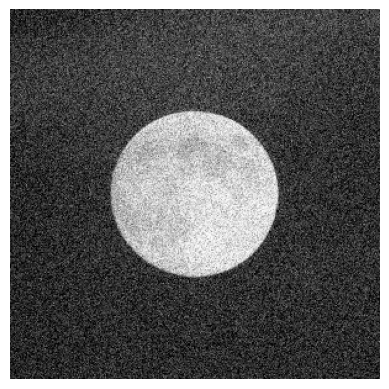

In [4]:
plt.imshow(moon_image, cmap='gray')
plt.axis('off')

In [5]:
kernel_size = [5, 29, 129]

In [6]:
def imageBlur(image, boxSize = 1):
    kernel = np.ones((boxSize,boxSize))/(boxSize**2)
    convolved_image = scipy.ndimage.convolve(image, kernel)
    return convolved_image

for m = 5, Optimal Threshold is: 126 and Least Intra-Class Variance is: 169.77529823861505
for m = 29, Optimal Threshold is: 120 and Least Intra-Class Variance is: 287.4666692407548
for m = 129, Optimal Threshold is: 91 and Least Intra-Class Variance is: 270.68913452496747


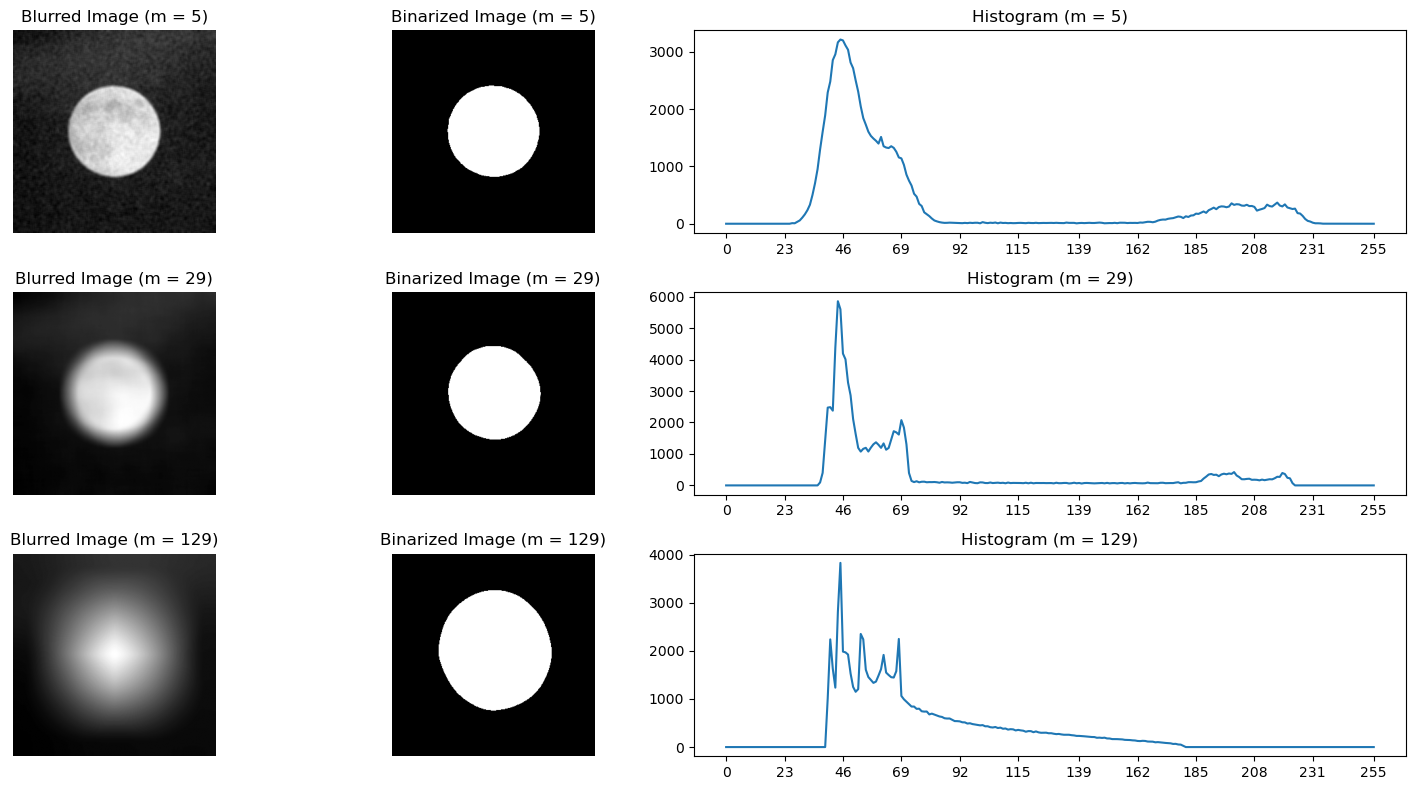

In [7]:
fig,axes = plt.subplots(nrows=len(kernel_size), ncols=3, figsize=(15,8), gridspec_kw={'width_ratios':[1,1,2]})
for i in range(len(kernel_size)):
    blurImage = imageBlur(moon_image, kernel_size[i])
    threshold, min_intraVar = findThreshold(blurImage)
    print(f'''for m = {kernel_size[i]}, Optimal Threshold is: {threshold} and Least Intra-Class Variance is: {min_intraVar}''')

    histogram = Histogram(blurImage)
    bin_image = showBinImage(blurImage, threshold)

    axes[i,0].imshow(blurImage, cmap='gray')
    axes[i,0].axis('off')
    axes[i,0].set_title(f'''Blurred Image (m = {kernel_size[i]})''')
    axes[i,1].imshow(bin_image, cmap='gray')
    axes[i,1].axis('off')
    axes[i,1].set_title(f'''Binarized Image (m = {kernel_size[i]})''')
    axes[i,2].plot(histogram)
    axes[i,2].set_xticks(np.linspace(0, 255, num=12, dtype=int))
    axes[i,2].set_title(f'''Histogram (m = {kernel_size[i]})''')
fig.tight_layout()
plt.show()

# Q2 Spatial Filtering and Binarization

In [8]:
flower_image = np.array(Image.open("images/flowers.png").convert('L'))
flower_height, flower_width = flower_image.shape

In [30]:
def bilinearInterpolation(image, x, y):
    x1, y1 = np.floor(x).astype(np.uint64), np.floor(y).astype(np.uint64)
    x2, y2 = min(x1 + 1, image.shape[0] - 1), min(y1 + 1, image.shape[1] - 1)
    dx, dy = x - x1, y - y1
    w11, w12, w21, w22 = (1 - dx) * (1 - dy), (1 - dx) * dy, dx * (1 - dy), dx * dy
    value = ((w11 * image[x1,y1]) + (w21 * image[x2,y1]) + (w12 * image[x1,y2]) + (w22 * image[x2,y2])).astype(np.uint8)
    return value

In [10]:
def zoom(image, scale=1):
    scaled_img = np.zeros(np.array(image.shape)*scale)
    for i in range(scaled_img.shape[0]):
        for j in range(scaled_img.shape[1]):
            x,y = i/scale, j/scale
            scaled_img[i,j] = bilinearInterpolation(image, x, y)
    return scaled_img

In [38]:
def rotateImage(image, deg = 0):
    if deg == 0:
        return image
        
    rad = deg * np.pi / 180
    sin, cos = np.sin(rad), np.cos(rad)

    image_height, image_width = image.shape

    r_img_width = np.floor(np.abs(image_width * cos) + np.abs(image_height * sin)).astype(np.uint64)
    r_img_height = np.floor(np.abs(image_width * sin) + np.abs(image_height * cos)).astype(np.uint64)
    rotated_image = np.zeros((r_img_height, r_img_width))
    i_center, j_center = (r_img_height - 1) / 2, (r_img_width - 1) / 2
    x_center, y_center = (image_height - 1) / 2, (image_width - 1) / 2

    for i in range(r_img_height):
        i_temp = i - i_center
        for j in range(r_img_width):
            j_temp = j - j_center
            
            x = (i_temp * cos) - (j_temp * sin) + x_center
            y = (i_temp * sin) + (j_temp * cos) + y_center
    
            if(x >= 0 and x < image_height and y >= 0 and y < image_width):
                rotated_image[i,j] = bilinearInterpolation(image, x, y)
    return rotated_image

In [47]:
result1 = rotateImage(zoom(flower_image, 2), 45)
res1.shape

(886, 886)

In [40]:
result2 = zoom(rotateImage(flower_image, 45), 2)
result2.shape

(886, 886)

Text(0.5, 1.0, 'Rotate and Zoom')

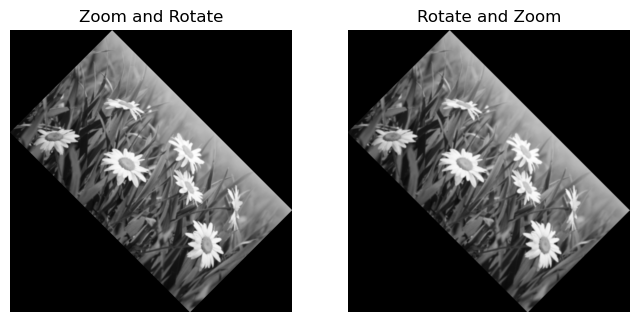

In [48]:
fig,axes = plt.subplots(nrows=1, ncols=2, figsize=(8,4))
axes[0].imshow(res1, cmap='gray')
axes[0].axis('off')
axes[0].set_title("Zoom and Rotate")
axes[1].imshow(result2, cmap='gray')
axes[1].axis('off')
axes[1].set_title("Rotate and Zoom")

In [49]:
diff = result1 - result2

In [50]:
np.min(diff), np.max(result2)

(np.float64(-178.0), np.float64(250.0))

Text(0.5, 1.0, 'Difference with vmin,vmax')

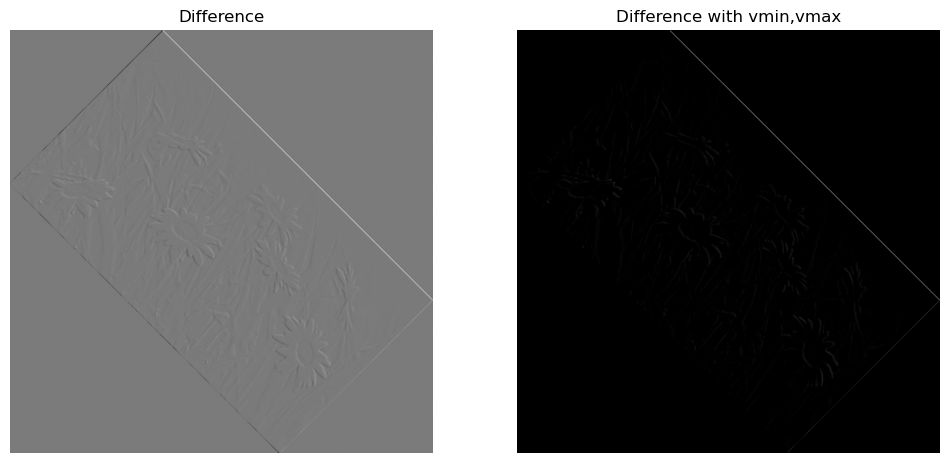

In [51]:
fig,axes = plt.subplots(nrows=1, ncols=2, figsize=(12,8))
axes[0].imshow(diff, cmap='gray')
axes[0].axis('off')
axes[0].set_title("Difference")
axes[1].imshow(diff, cmap='gray', vmin = 0, vmax = 255)
axes[1].axis('off')
axes[1].set_title("Difference with vmin,vmax")

# Q3 Image Sharpening Concept

In [55]:
def unsharpMasking(image, power = 0):
    blur_image = imageBlur(image, 11).astype(np.float32)
    sharp_image = image + power * (image - blur_image)
    return sharp_image

In [64]:
def applyUnsharpMasking(image):
    power = [0, 0.5, 1]
    fig,axes = plt.subplots(nrows=2, ncols=2, figsize=(10,8))
    axes[0,0].imshow(image, cmap='gray', vmin = 0, vmax = 255)
    axes[0,0].axis('off')
    axes[0,0].set_title(f'''Orignal Image''')
    for i in range(len(power)):
        axes[int(bool(i)), abs(1-i)].imshow(unsharpMasking(image, power[i]), cmap='gray', vmin = 0, vmax = 255)
        axes[int(bool(i)), abs(1-i)].axis('off')
        axes[int(bool(i)), abs(1-i)].set_title(f'''Sharpened Image with p = {power[i]}''')
    fig.tight_layout()
    plt.show()

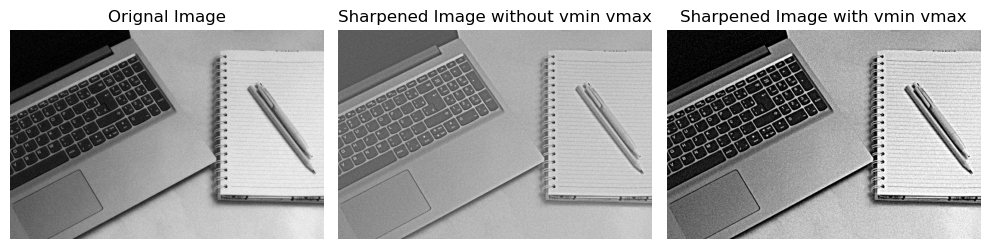

In [72]:
study_image = np.array(Image.open("images/study.png").convert('L'))
sharp_image = unsharpMasking(study_image, 1)
fig,axes = plt.subplots(nrows=1, ncols=3, figsize=(10,8))
axes[0].imshow(study_image, cmap='gray', vmin = 0, vmax = 255)
axes[0].axis('off')
axes[0].set_title(f'''Orignal Image''')
axes[1].imshow(sharp_image, cmap='gray')
axes[1].axis('off')
axes[1].set_title(f'''Sharpened Image without vmin vmax''')
axes[2].imshow(sharp_image, cmap='gray', vmin = 0, vmax = 255)
axes[2].axis('off')
axes[2].set_title(f'''Sharpened Image with vmin vmax''')
fig.tight_layout()
plt.show()

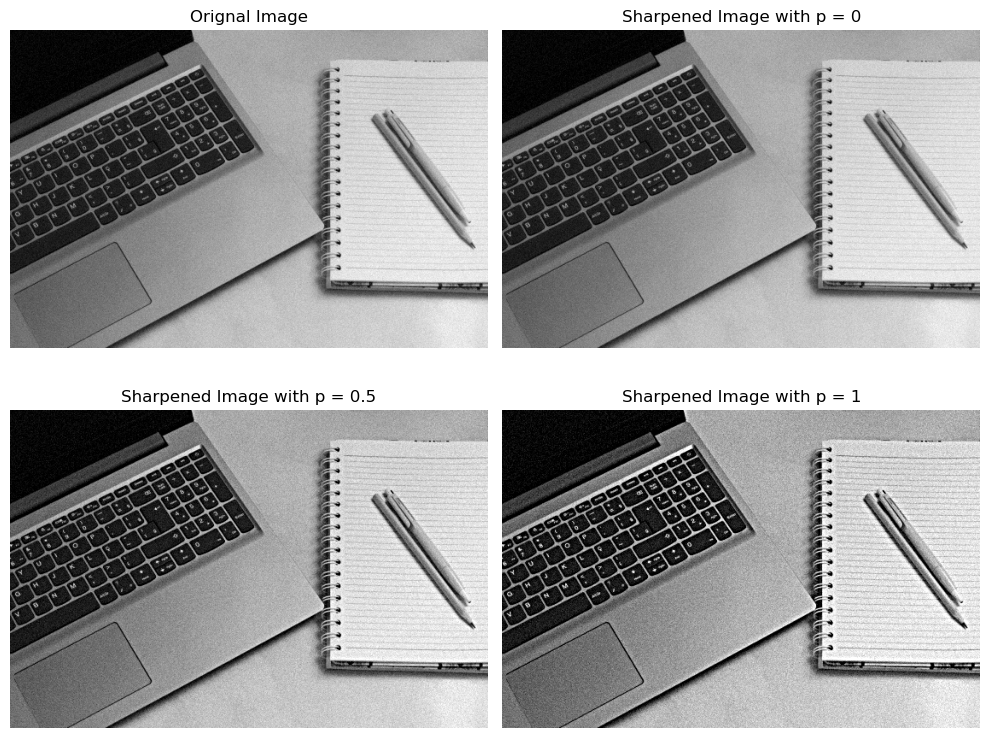

In [65]:
applyUnsharpMasking(np.array(Image.open("images/study.png").convert('L')))

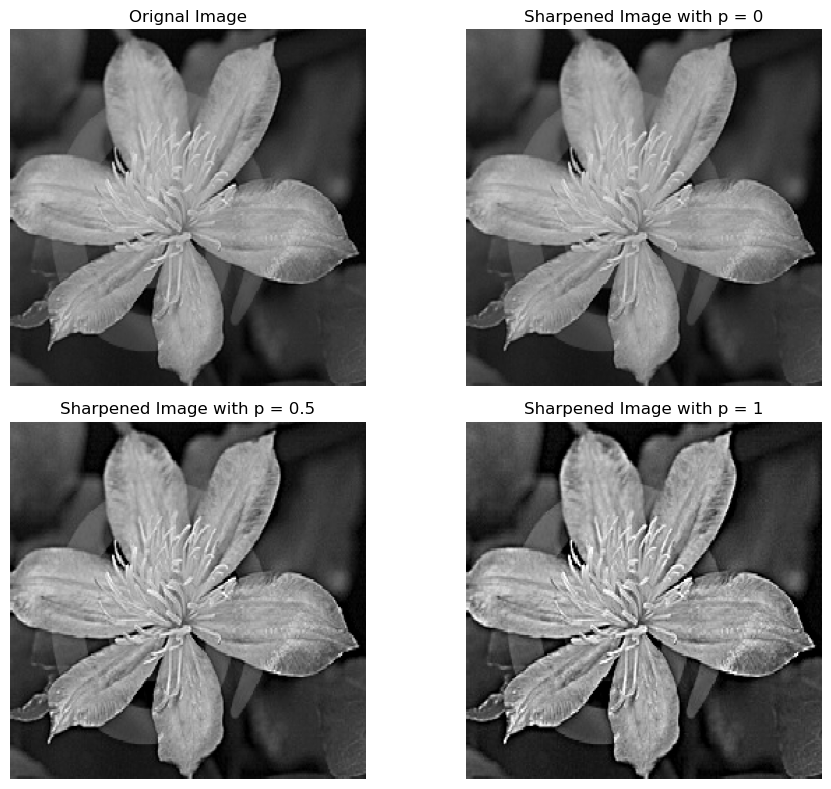

In [58]:
applyUnsharpMasking(np.array(Image.open("images/Flower.png").convert('L')))

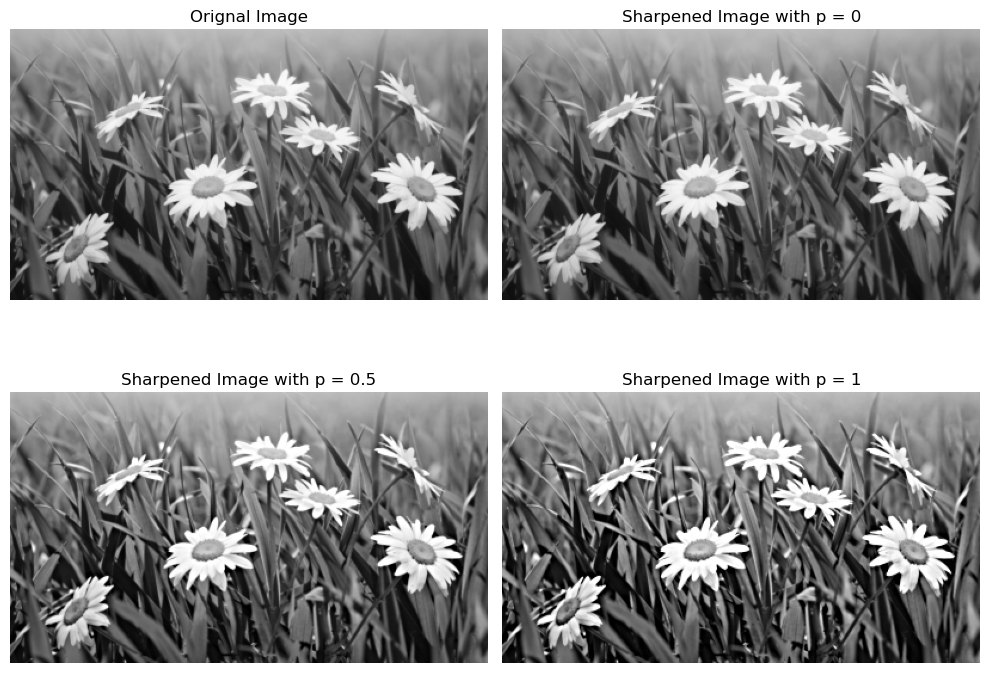

In [59]:
applyUnsharpMasking(np.array(Image.open("images/flowers.png").convert('L')))

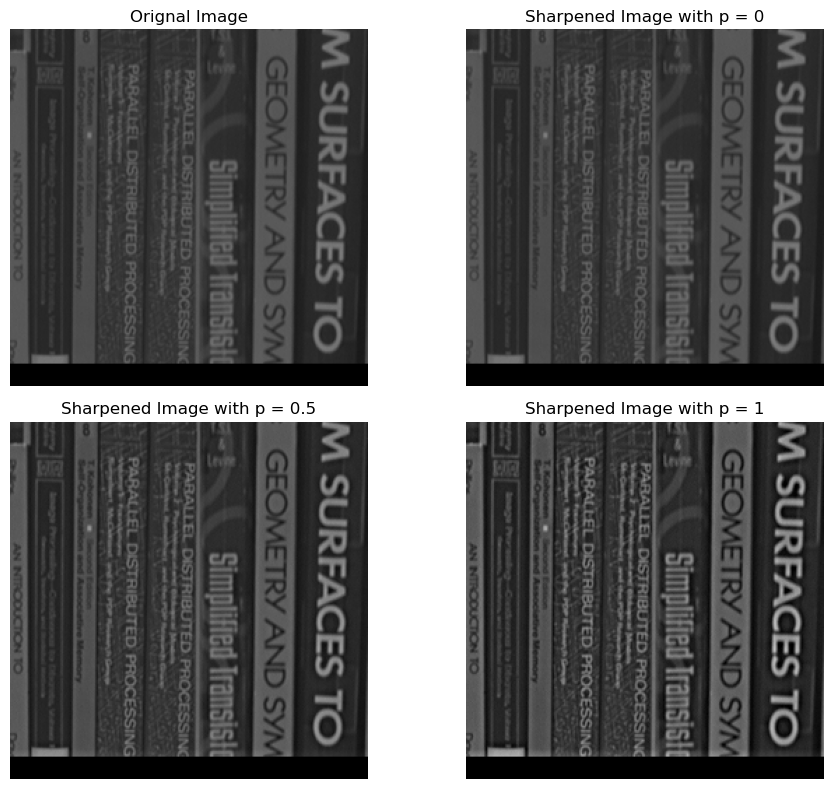

In [60]:
applyUnsharpMasking(np.array(Image.open("images/Books.png").convert('L')))

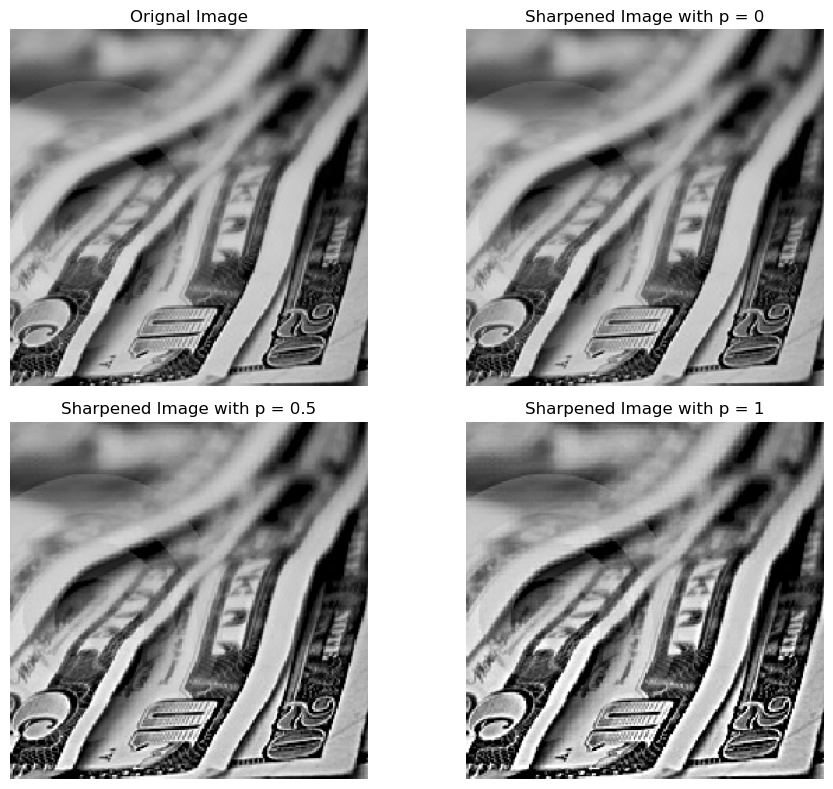

In [61]:
applyUnsharpMasking(np.array(Image.open("images/money.png").convert('L')))